**About dataset**

The dataset utilized for analysis and classification comes from Kaggle and is titled "Confused Student EEG Brainwave Data." The specific file used for this purpose is EEG_data.csv. To see description about the dataset please follow this link https://www.kaggle.com/datasets/wanghaohan/confused-eeg .

# Data Exploration

## Import the required dataset


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/numbstudent/Confused-Student-EEG-Brainwave-Data-Classification-using-XGBoost/main/EEG_data.csv', encoding='utf-8')
df

SubjectID  VideoID  Attention  Mediation    Raw      Delta      Theta  \
0            0.0      0.0       56.0       43.0  278.0   301963.0    90612.0   
1            0.0      0.0       40.0       35.0  -50.0    73787.0    28083.0   
2            0.0      0.0       47.0       48.0  101.0   758353.0   383745.0   
3            0.0      0.0       47.0       57.0   -5.0  2012240.0   129350.0   
4            0.0      0.0       44.0       53.0   -8.0  1005145.0   354328.0   
...          ...      ...        ...        ...    ...        ...        ...   
12806        9.0      9.0       64.0       38.0  -39.0   127574.0     9951.0   
12807        9.0      9.0       61.0       35.0 -275.0   323061.0   797464.0   
12808        9.0      9.0       60.0       29.0 -426.0   680989.0   154296.0   
12809        9.0      9.0       60.0       29.0  -84.0   366269.0    27346.0   
12810        9.0      9.0       64.0       29.0  -49.0  1164555.0  1184366.0   

         Alpha1    Alpha2    Beta1     Beta2   Gamma1   Gamma2  \
0       33735.0   23991.0  27946.0   45097.0  33228.0   8293.0   
1        1439.0    2240.0   2746.0    3687.0   5293.0   2740.0   
2      201999.0   62107.0  36293.0  130536.0  57243.0  25354.0   
3       61236.0   17084.0  11488.0   62462.0  49960.0  33932.0   
4       37102.0   88881.0  45307.0   99603.0  44790.0  29749.0   
...         ...       ...      ...       ...      ...      ...   
12806     709.0   21732.0   3872.0   39728.0   2598.0    960.0   
12807  153171.0  145805.0  39829.0  571280.0  36574.0  10010.0   
12808   40068.0   39122.0  10966.0   26975.0  20427.0   2024.0   
12809   11444.0    9932.0   1939.0    3283.0  12323.0   1764.0   
12810   50014.0  124208.0  10634.0  445383.0  22133.0   4482.0   

       predefinedlabel  user-definedlabeln  
0                  0.0                 0.0  
1                  0.0                 0.0  
2                  0.0                 0.0  
3                  0.0                 0.0  
4                  0.0                 0.0  
...                ...                 ...  
12806              1.0                 0.0  
12807              1.0                 0.0  
12808              1.0                 0.0  
12809              1.0                 0.0  
12810              1.0                 0.0  

[12811 rows x 15 columns]

## Manipulate the dataset
Each trial is given timepoints, since timepoint is not available from the imported data.

In [3]:
df = df.rename(columns={"user-definedlabeln": "userlabel"})


In [4]:
df_new = df.reset_index().drop(df.index)

for i in range(0,10):
  for j in range(0,10):
    query = "SubjectID == "+str(i)+" & VideoID == "+str(j)
    df_temp = df.query(query)
    df_temp = df_temp.reset_index(drop=True)
    df_temp = df_temp.reset_index()
    # print(df_temp)
    df_new = pd.concat([df_new, df_temp])

df_new = df_new.rename(columns={"index": "timepoint"})
df_new = df_new.reset_index(drop=True)
df_new.head()

timepoint  SubjectID  VideoID  Attention  Mediation    Raw      Delta  \
0          0        0.0      0.0       56.0       43.0  278.0   301963.0   
1          1        0.0      0.0       40.0       35.0  -50.0    73787.0   
2          2        0.0      0.0       47.0       48.0  101.0   758353.0   
3          3        0.0      0.0       47.0       57.0   -5.0  2012240.0   
4          4        0.0      0.0       44.0       53.0   -8.0  1005145.0   

      Theta    Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  \
0   90612.0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0   
1   28083.0    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0   
2  383745.0  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0   
3  129350.0   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0   
4  354328.0   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0   

   predefinedlabel  userlabel  
0              0.0        0.0  
1              0.0        0.0  
2              0.0        0.0  
3              0.0        0.0  
4              0.0        0.0

## Observe characteristics (confused / not confused) by group of frequencies

### Find out correlations between each feature

To identify strong candidates for features, we will apply a correlation matrix to the dataset.

Based on the plot below, it appears that the relationship between each feature is weak. However, it is worth noting that VideoID exhibits a relatively strong correlation with the label. Nevertheless, since VideoID is not intended to be treated as a feature, we will omit this observation. Furthermore, we observe that the correlation between the label and other features is weak.




<AxesSubplot:>

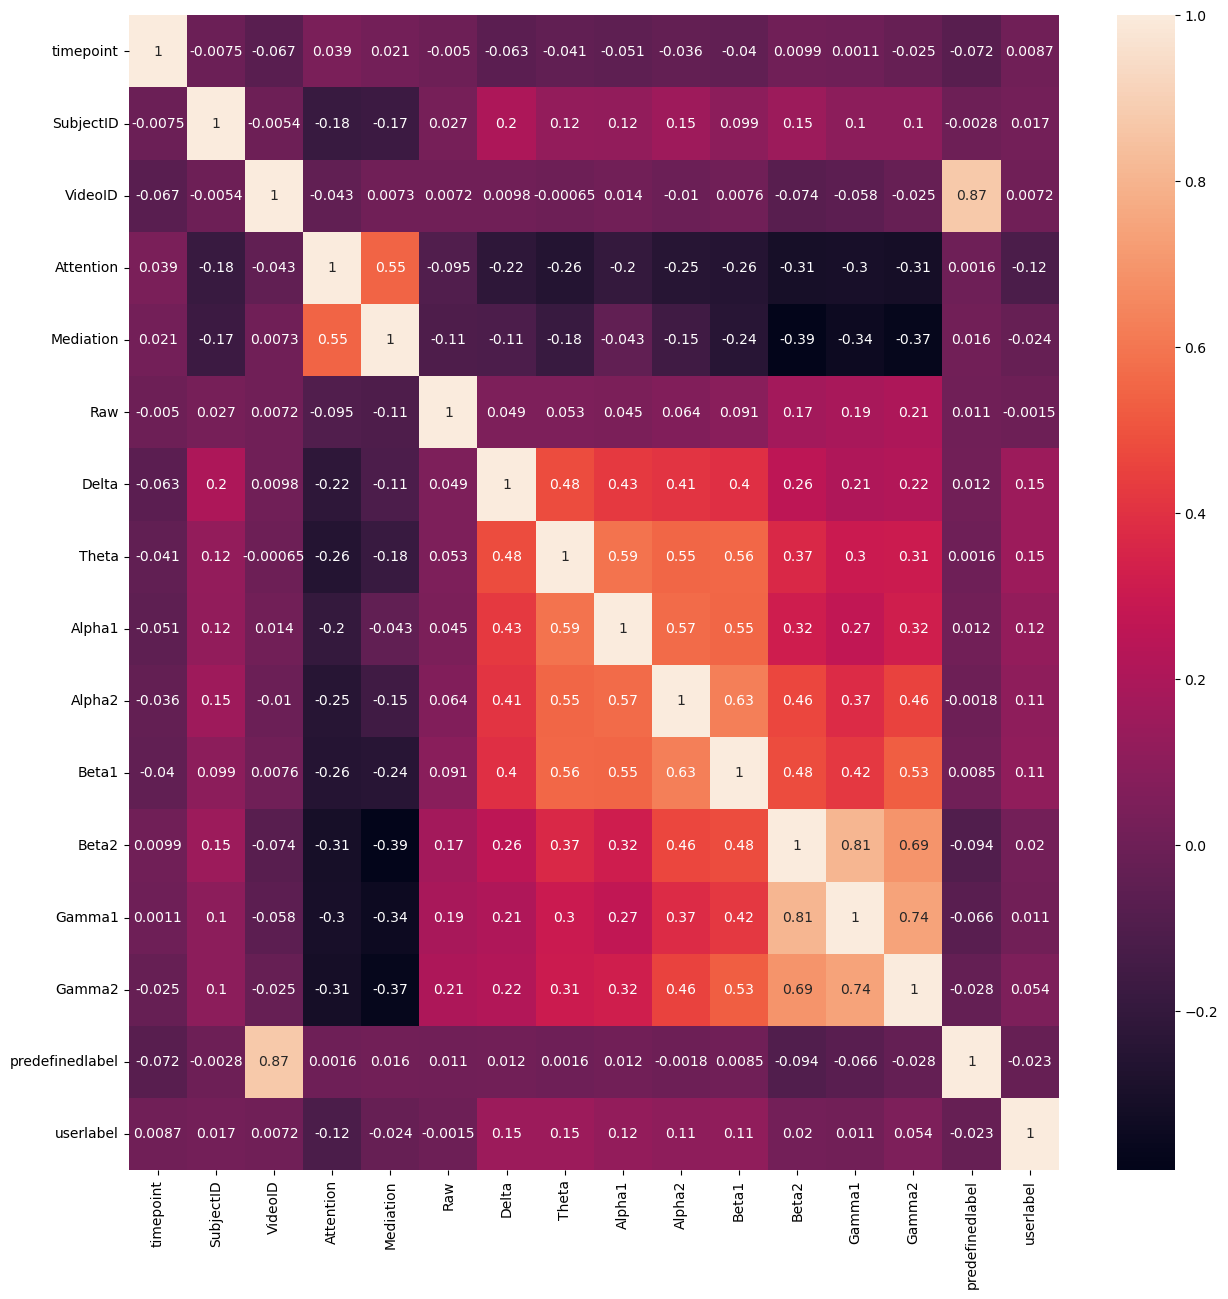

In [5]:
plt.figure(figsize = (15,15))
cor_matrix = df_new.corr()
sns.heatmap(cor_matrix,annot=True)

### Compare the labels by averaging the signals grouped according to their respective labels.

In the next step, we aim to compare the timepoints of confused versus not confused signals. To achieve this, we will categorize the signals into three categories based on the method of labeling: labeled by the author, labeled by the subjects, and labeled by both the author and the subjects. Once the signals are categorized according to their labels, we will compute the average for each timepoint.

In [6]:
def draw_multiple_figures(df_confused,df_understand):
  sns.set(rc={'figure.figsize':(30,8.27)})

  fig, axs = plt.subplots(5, 2)

  sns.lineplot(data=df_confused, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])

  sns.lineplot(data=df_confused, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])
  sns.lineplot(data=df_understand, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])

  sns.lineplot(data=df_confused, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])
  sns.lineplot(data=df_understand, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])

  fig.legend(labels=['confused','not confused'], loc="lower center", ncol=2)
  fig.suptitle("Confused vs Not Confused by Groups of Frequency")

  plt.show()

### Comparison between Confused vs Not Confused in dataset labeled by the author.

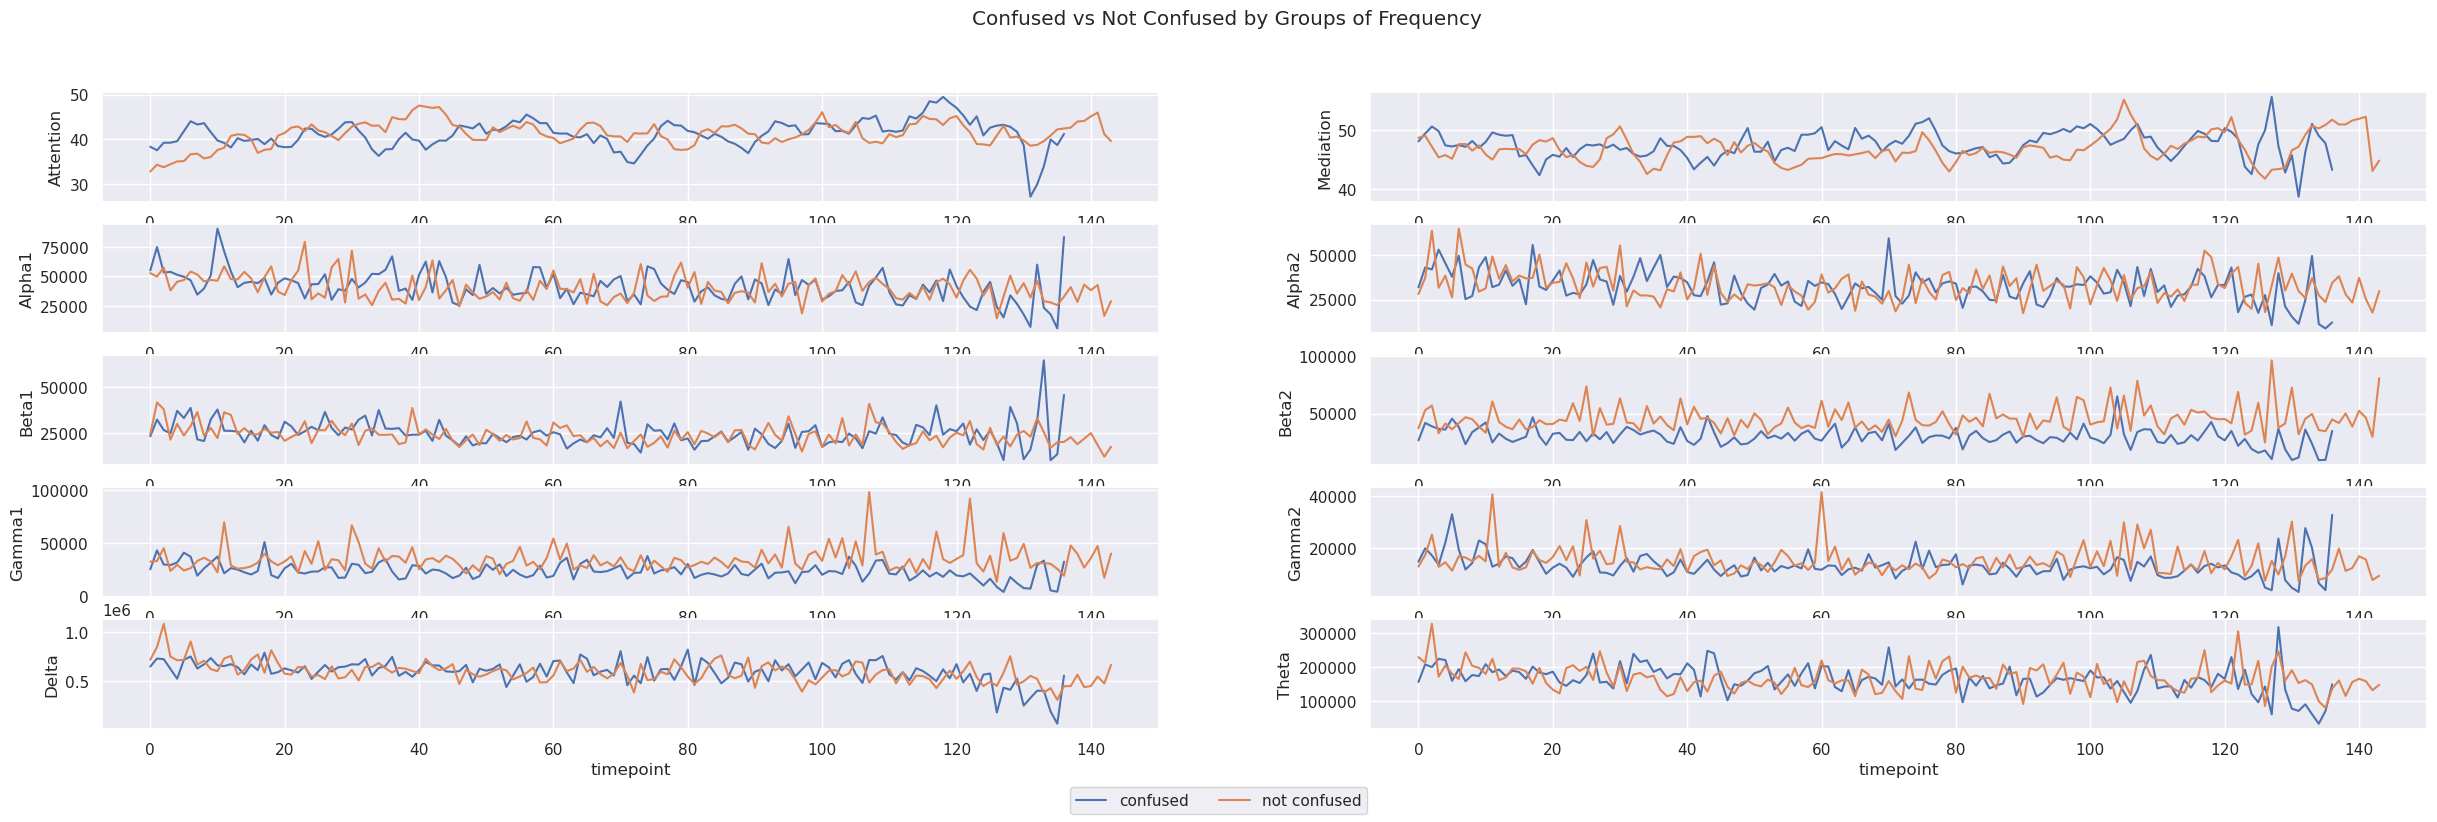

In [7]:
query = "predefinedlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

### Comparison between Confused vs Not Confused in dataset labeled by subjects.

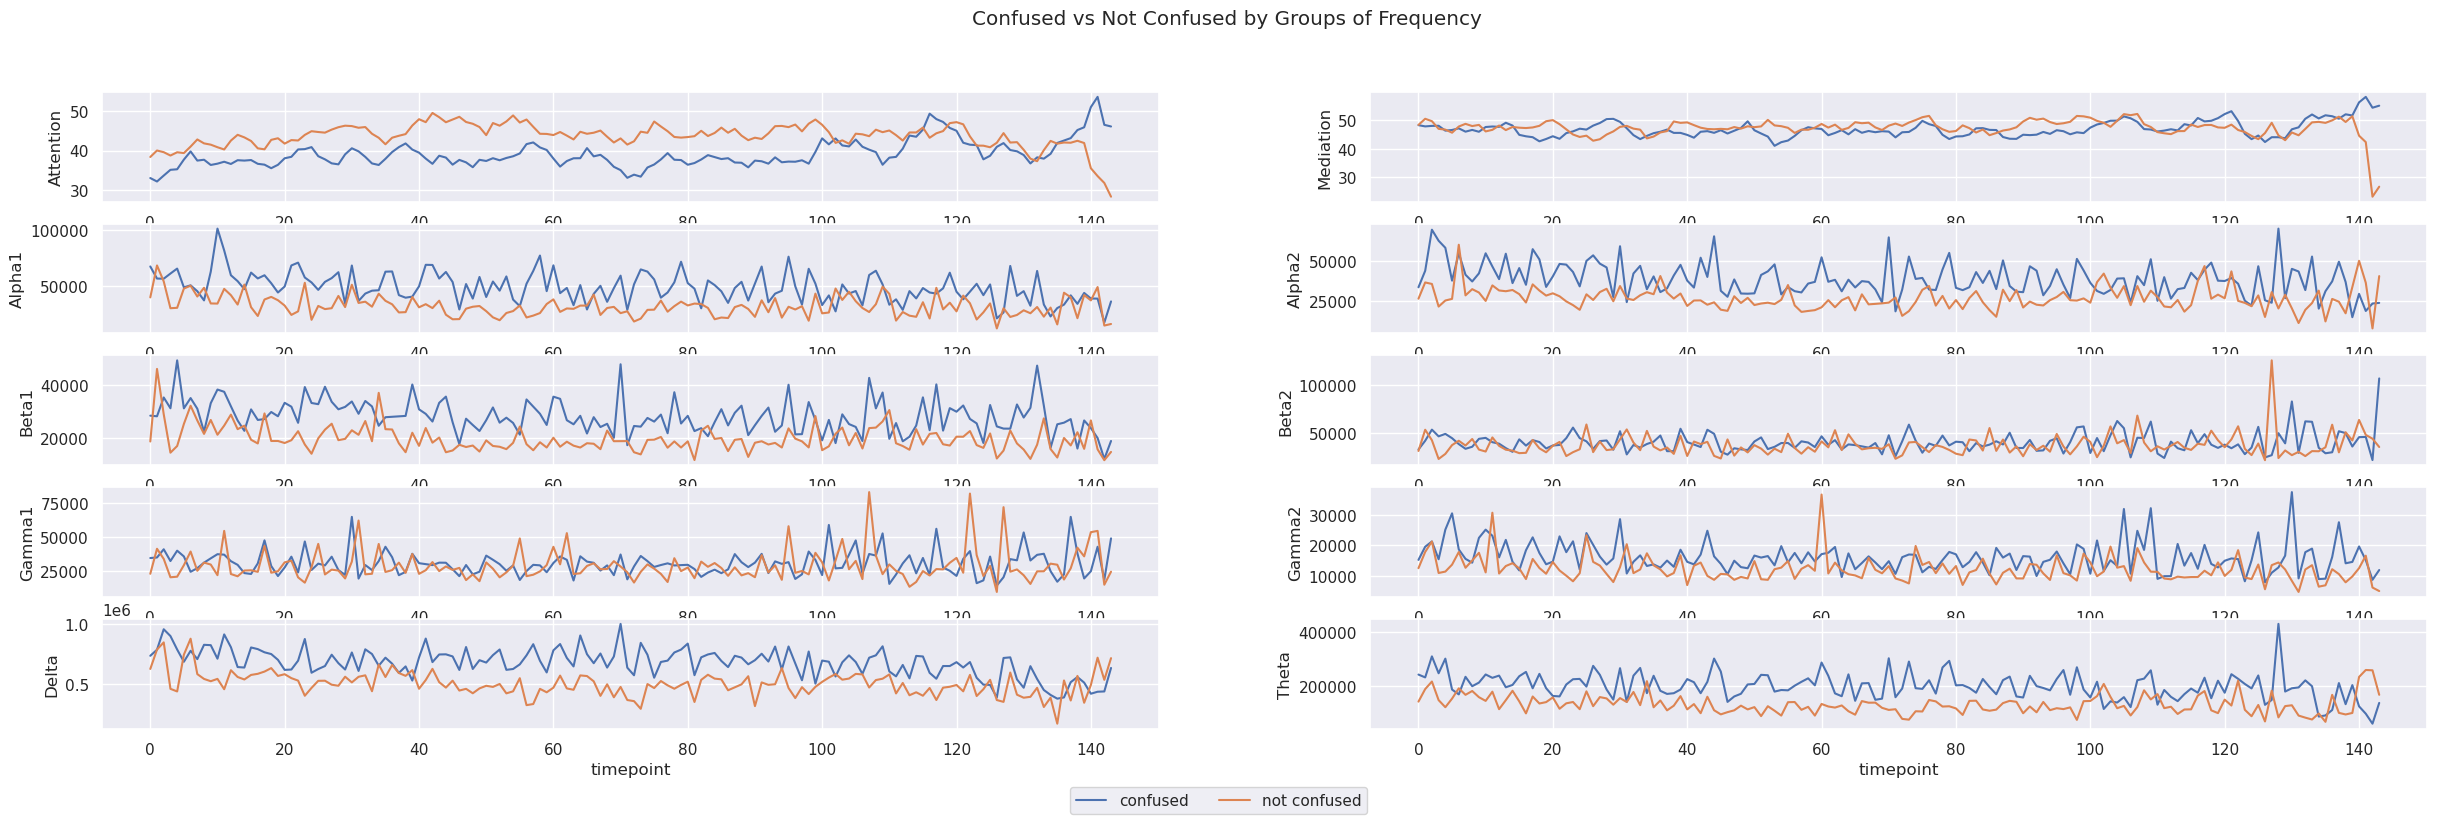

In [8]:
query = "userlabel == 1"
df_confused = df_new.query(query)

query = "userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

### Comparison between Confused vs Not Confused in dataset same-labeled by the author and subjects.

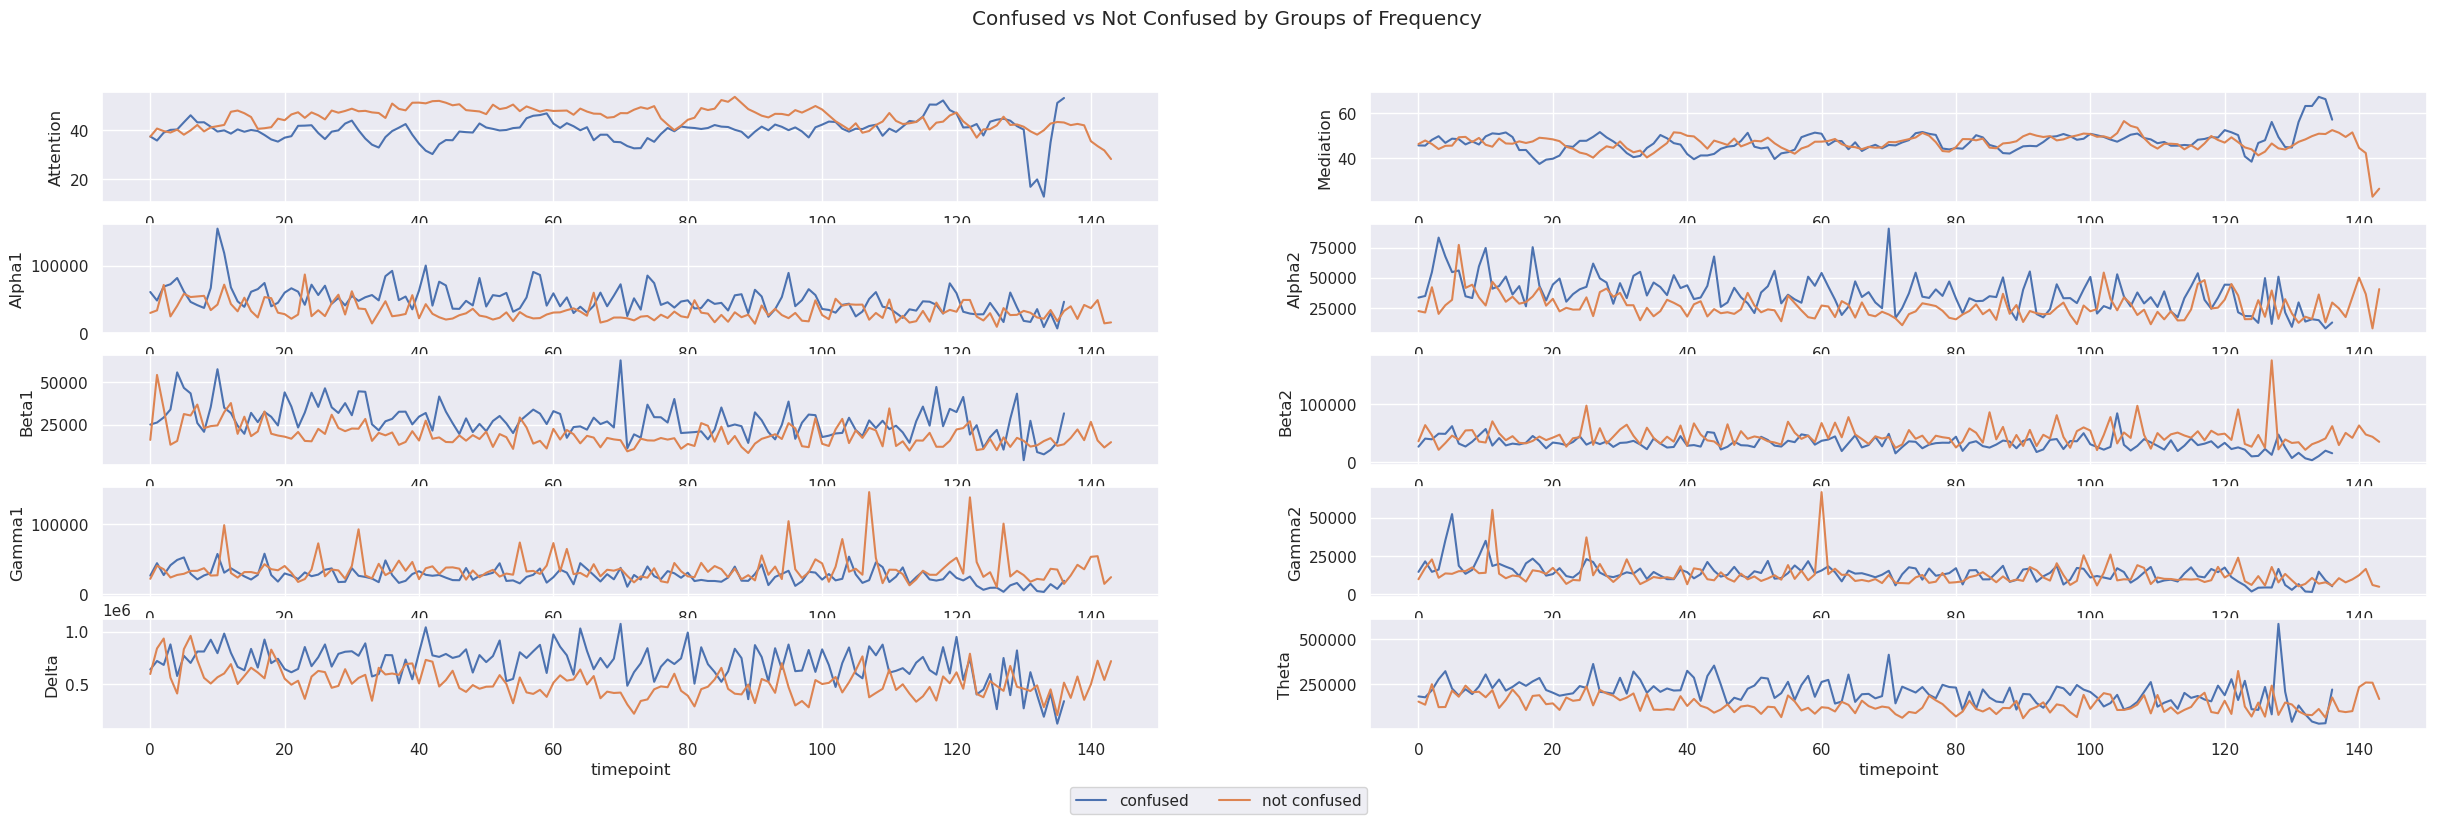

In [9]:
query = "predefinedlabel == 1 & userlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
df_understand = df_new.query(query)

draw_multiple_figures(df_confused,df_understand)

By plotting the signals according to their respective frequency and categorizing their labels using the same-labeled by author and subjects criteria, we can observe that the labels can be easily distinguished from the Beta1, Delta, and Gamma plots.

# Data Training and Classification

## Training dataset preparation, using only data same-labeled by the author and subjects



In [10]:
df_true = df_new.query("(predefinedlabel == 0 & userlabel == 0) | (predefinedlabel == 1 & userlabel == 1)")
X = df_true[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]
	
print(X.isna().sum())
print(X.shape)
Y = df_true.predefinedlabel
print(Y.shape)

Delta     0
Theta     0
Alpha1    0
Alpha2    0
Beta1     0
Beta2     0
Gamma1    0
Gamma2    0
dtype: int64
(6253, 8)
(6253,)


In [11]:
print(df_true[df_true['predefinedlabel'] == 1].shape)
print(df_true[df_true['predefinedlabel'] == 0].shape)
print(df_true.shape)

(3079, 16)
(3174, 16)
(6253, 16)


## Classification using XGBoost

### Run the classification

In [12]:
def classify(X,Y):
  import xgboost
  random_state = 42

  x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,
                                  random_state=random_state, stratify=Y)

  model = xgboost.XGBClassifier(base_score=0.5, learning_rate=0.1,max_depth=6,
          objective='binary:logistic', eta=0.01)
  model.fit(x_train, y_train)

  y_pred = model.predict(x_test)
  predictions = [round(value) for value in y_pred]

  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))

  ## draw the tree
  from xgboost import plot_tree
  from matplotlib.pylab import rcParams

  rcParams['figure.figsize'] = 80,50

  plot_tree(model)
  plt.show()

  ## show the cross validation result
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import cross_val_score

  kfold = StratifiedKFold(n_splits=5)
  results = cross_val_score(model, X, Y, cv=kfold)
  print("Cross Validation Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
  print("")
  print("---------------------------------------------------------------------")
  print("")

  ## print feature importance
  print("Feature Importance")
  rcParams['figure.figsize'] = 5,5
  from xgboost import plot_importance
  plot_importance(model)
  plt.show()

Accuracy: 66.59%


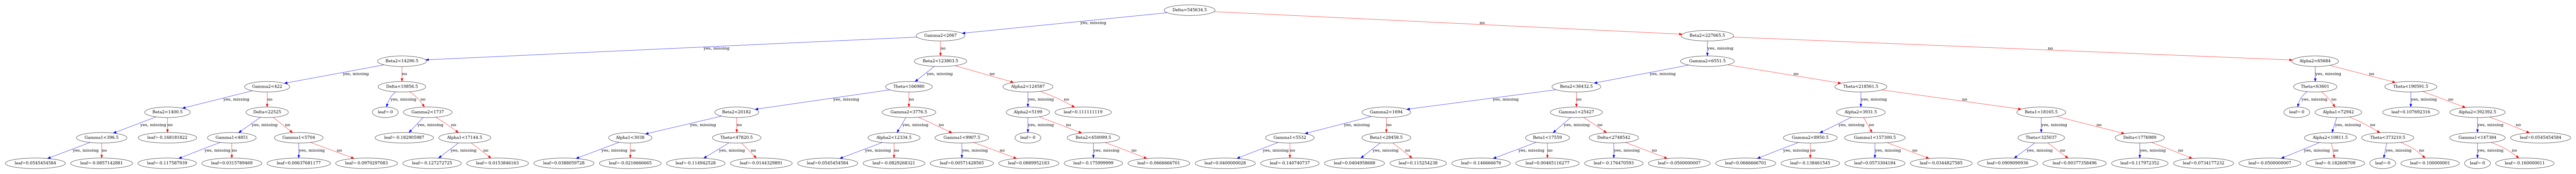

Cross Validation Accuracy: 60.82% (5.96%)

---------------------------------------------------------------------

Feature Importance


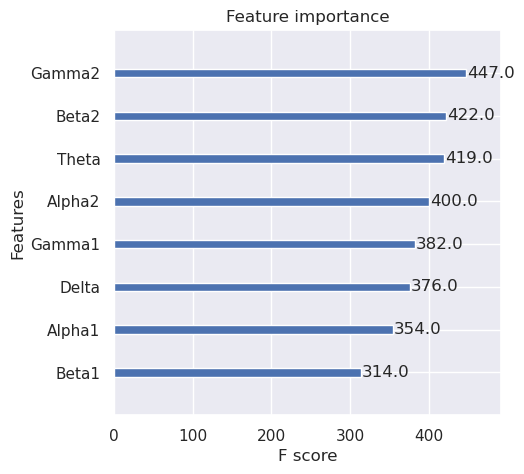

In [13]:
classify(X,Y)

The accuracy achieved was 66.59%, while the cross-validation score was 60.82%, which is not ideal. Therefore, we will apply a moving average to the data to smooth out the values.

### Applying moving average to each feature

Next, we will apply a moving average to the data to address the issue of dispersed values. Following this, we will re-run the classification using XGBoost.

In [14]:
def moving_average(x, w = 10):
    return np.convolve(x, np.ones(w), 'valid') / w

In [15]:
df_ma = pd.DataFrame(columns = ['Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2','Label'])

for i in range(int(df_true.SubjectID.min()), int(df_true.SubjectID.max()+1)):
  for j in range(int(df_true.VideoID.min()), int(df_true.VideoID.max()+1)):
    for k in range(0,2):
      if len(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Attention) > 0 :
        attention = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Attention)
        mediation = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Mediation)
        delta = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Delta)
        theta = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Theta)
        alpha1 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Alpha1)
        alpha2 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Alpha2)
        beta1 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Beta1)
        beta2 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Beta2)
        gamma1 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Gamma1)
        gamma2 = moving_average(df_true[(df_true.predefinedlabel == k) & (df_true.SubjectID == i) & (df_true.VideoID == j)].Gamma2)
        if k == 1:
          label = np.ones(len(attention))
        else:
          label = np.zeros(len(attention))
        timepoint = np.arange(len(attention))
        array = np.stack((timepoint, attention, mediation, delta, theta, alpha1, alpha2, beta1, beta2, gamma1, gamma2, label))
        array = np.transpose(array)
        df_temp = pd.DataFrame(array, columns = ['timepoint','Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2','Label'])
        df_ma = pd.concat([df_ma, df_temp])

print(df_ma)

     Attention  Mediation     Delta     Theta   Alpha1   Alpha2    Beta1  \
0         45.1       57.0  730906.7  153457.8  59794.7  38078.0  22875.2   
1         44.3       56.5  776426.9  163016.2  56745.4  36063.0  21966.0   
2         44.7       57.8  835799.5  174393.3  64106.5  37462.4  26284.0   
3         44.7       56.4  776500.2  140230.7  44222.4  31877.3  23381.7   
4         44.8       53.7  649042.7  135723.2  38322.3  34043.7  24403.4   
..         ...        ...       ...       ...      ...      ...      ...   
110       59.7       52.9  696266.1  134271.3  24167.2  19734.7  20748.9   
111       59.4       52.6  728067.2  147023.7  47176.4  24000.7  27738.6   
112       56.8       51.9  647406.8  141006.7  45746.4  23283.2  23621.7   
113       55.9       51.9  790189.1  159394.5  47639.8  23119.3  25662.5   
114       54.1       52.1  789421.8  161619.5  47606.7  23170.1  25701.0   

       Beta2   Gamma1   Gamma2  Label  timepoint  
0    54852.8  39680.7  25812.9    0.

In [16]:
X_ma = df_ma[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]
	
print(X.isna().sum())
print(X.shape)
Y_ma = df_ma.Label
print(Y.shape)

Delta     0
Theta     0
Alpha1    0
Alpha2    0
Beta1     0
Beta2     0
Gamma1    0
Gamma2    0
dtype: int64
(6253, 8)
(6253,)


Accuracy: 88.39%


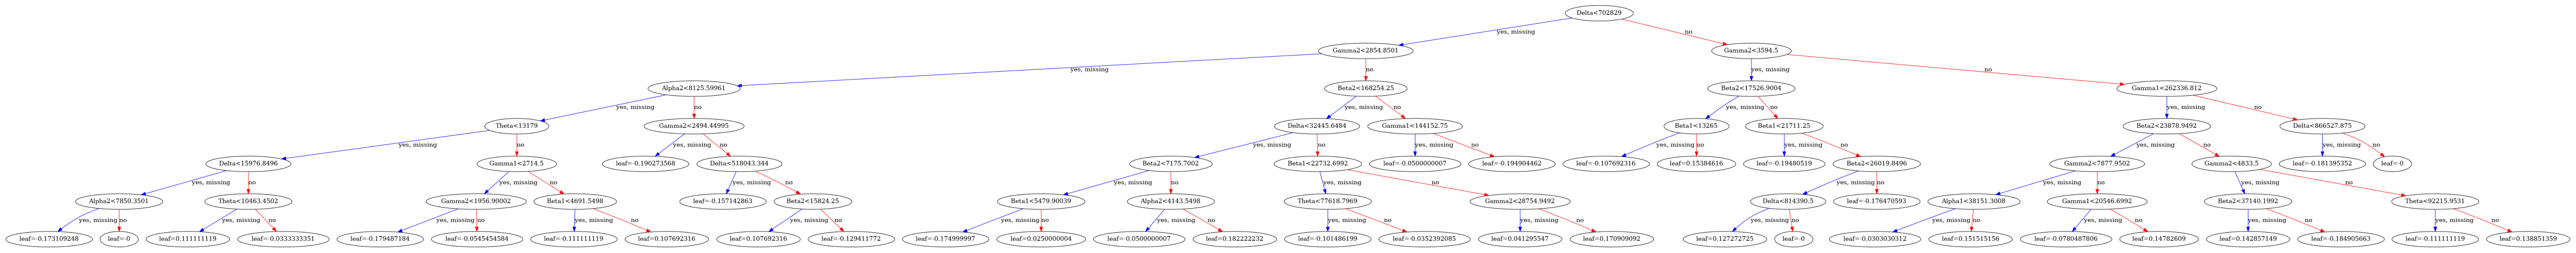

Cross Validation Accuracy: 67.40% (11.27%)

---------------------------------------------------------------------

Feature Importance


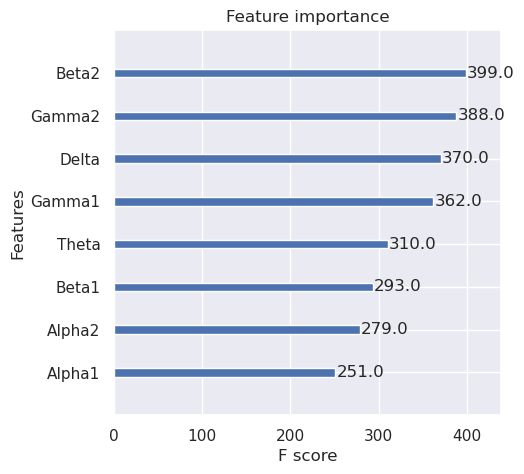

In [17]:
classify(X_ma,Y_ma)

The application of moving average has resulted in an improved accuracy score of 88.39%. However, the cross-validation score remains relatively low at 67.40%.

In addition, we have observed changes in the order of important features. The top four features are now Beta2, Gamma2, Delta, and Gamma 1, respectively.

## Classification using Bidirectional LSTM

This method is based on the work of Shreyas P.J., and you can refer to the original source at https://www.kaggle.com/code/shreyaspj/confused-student-eeg-prediction/notebook. However, in this study, we have applied moving averages to the data instead of using the original data, and have focused solely on frequency-based features.

In [18]:
from sklearn.preprocessing import StandardScaler

X_ma = df_ma[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]

x_lstm = StandardScaler().fit_transform(X_ma)
y_lstm = Y_ma

x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm,test_size=0.2, random_state=42, stratify=y_lstm)


n_features = X_ma.shape[1]
x_train = np.array(x_train).reshape(-1,n_features,1)
x_test = np.array(x_test).reshape(-1,n_features,1)

x_train.shape, x_test.shape,y_train.shape,y_test.shape


((4649, 8, 1), (1163, 8, 1), (4649,), (1163,))

In [19]:
inputs = tf.keras.Input(shape=(n_features,1))

Dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)

lstm_1=  Bidirectional(LSTM(256, return_sequences = True))(Dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3=  Bidirectional(LSTM(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)

flat = Flatten()(drop2)

Dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation='sigmoid')(Dense_2)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 1)]            0         
                                                                 
 dense (Dense)               (None, 8, 64)             128       
                                                                 
 bidirectional (Bidirectiona  (None, 8, 512)           657408    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 512)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 8, 256)           656384    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 256)            0     

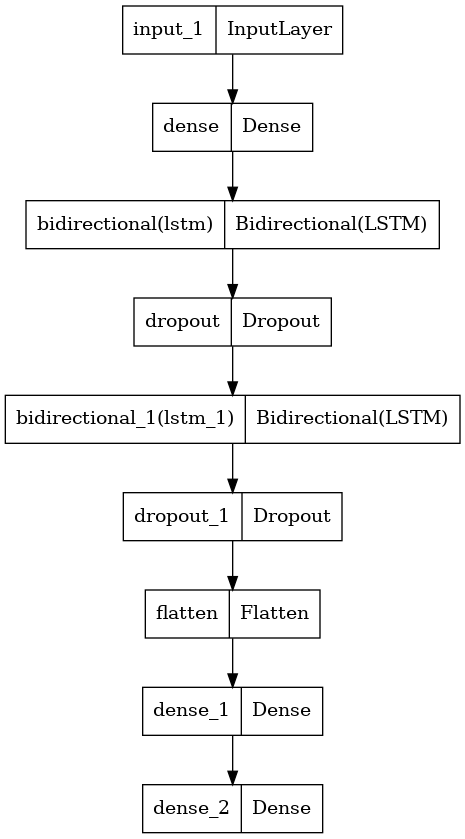

In [20]:
tf.keras.utils.plot_model(model)



Epoch 1: val_accuracy improved from -inf to 0.65348, saving model to ./_best_model_singleTrial.h5

Epoch 2: val_accuracy improved from 0.65348 to 0.69647, saving model to ./_best_model_singleTrial.h5

Epoch 3: val_accuracy improved from 0.69647 to 0.73259, saving model to ./_best_model_singleTrial.h5

Epoch 4: val_accuracy improved from 0.73259 to 0.74205, saving model to ./_best_model_singleTrial.h5

Epoch 5: val_accuracy improved from 0.74205 to 0.75924, saving model to ./_best_model_singleTrial.h5

Epoch 6: val_accuracy improved from 0.75924 to 0.80825, saving model to ./_best_model_singleTrial.h5

Epoch 7: val_accuracy improved from 0.80825 to 0.81771, saving model to ./_best_model_singleTrial.h5

Epoch 8: val_accuracy improved from 0.81771 to 0.82373, saving model to ./_best_model_singleTrial.h5

Epoch 9: val_accuracy improved from 0.82373 to 0.84437, saving model to ./_best_model_singleTrial.h5

Epoch 10: val_accuracy did not improve from 0.84437

Epoch 11: val_accuracy did not 

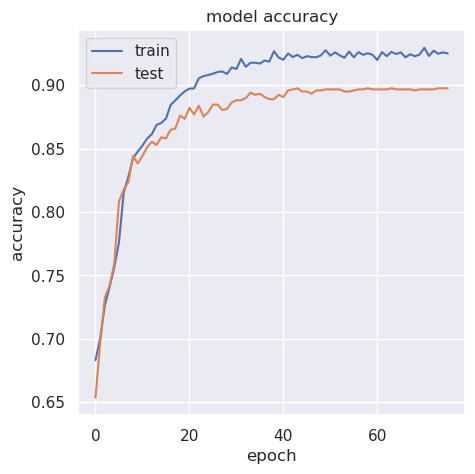

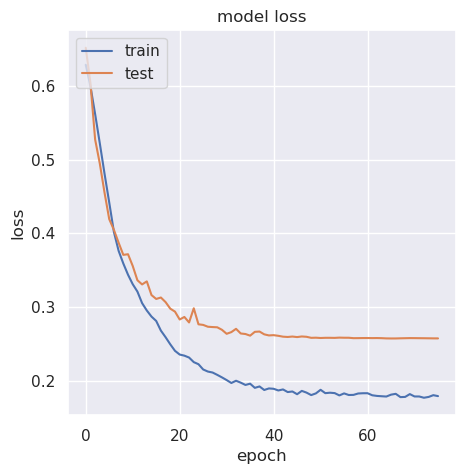

In [21]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, kfold_order=None, epoch = 2):
        if not kfold_order:
          kfold_order = 'singleTrial'
        else:
          print("=============================================================")
          print("Training for fold no "+str(kfold_order))
          print("=============================================================")
        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model_'+str(kfold_order)+'.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['binary_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=20,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule],verbose=0)
        
        saved_model = load_model(save_to + '_best_model_'+str(kfold_order)+'.h5')

        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 5,5

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        return model,history
        
model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', epoch = 100)

Our results demonstrate that applying a moving average and classifying using bidirectional LSTM has shown promising results, achieving accuracy of 92% with validation accuracy of 89%.

Next, we will validate the results once again using cross-validation.

Training for fold no 1

Epoch 1: val_accuracy improved from -inf to 0.85211, saving model to ./_best_model_1.h5

Epoch 2: val_accuracy improved from 0.85211 to 0.88220, saving model to ./_best_model_1.h5

Epoch 3: val_accuracy did not improve from 0.88220

Epoch 4: val_accuracy did not improve from 0.88220

Epoch 5: val_accuracy improved from 0.88220 to 0.88908, saving model to ./_best_model_1.h5

Epoch 6: val_accuracy improved from 0.88908 to 0.90542, saving model to ./_best_model_1.h5

Epoch 7: val_accuracy did not improve from 0.90542

Epoch 8: val_accuracy improved from 0.90542 to 0.90714, saving model to ./_best_model_1.h5

Epoch 9: val_accuracy did not improve from 0.90714

Epoch 10: val_accuracy did not improve from 0.90714

Epoch 11: val_accuracy did not improve from 0.90714

Epoch 12: val_accuracy improved from 0.90714 to 0.91831, saving model to ./_best_model_1.h5

Epoch 13: val_accuracy did not improve from 0.91831

Epoch 14: val_accuracy did not improve from 0.91831

Epoch 

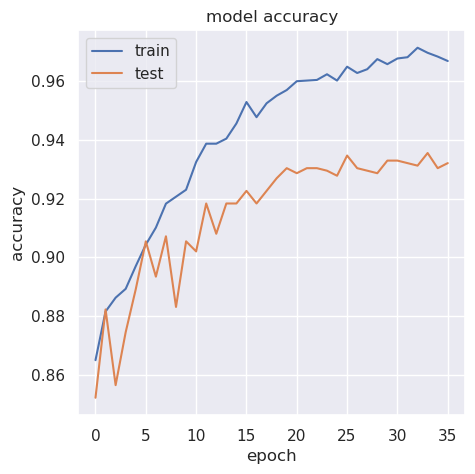

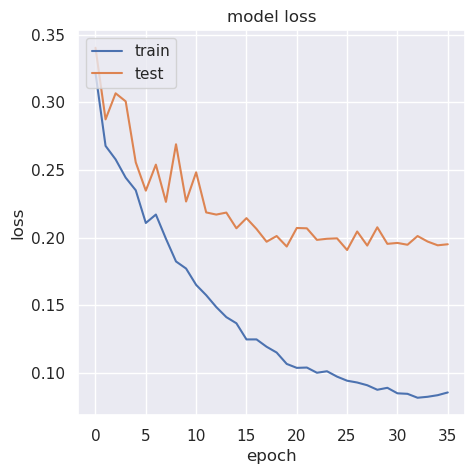

37/37 [==============================] - 0s 6ms/step - loss: 0.1971 - accuracy: 0.9355
Training for fold no 2

Epoch 1: val_accuracy improved from -inf to 0.93121, saving model to ./_best_model_2.h5

Epoch 2: val_accuracy did not improve from 0.93121

Epoch 3: val_accuracy did not improve from 0.93121

Epoch 4: val_accuracy did not improve from 0.93121

Epoch 5: val_accuracy did not improve from 0.93121

Epoch 6: val_accuracy did not improve from 0.93121

Epoch 7: val_accuracy improved from 0.93121 to 0.93207, saving model to ./_best_model_2.h5

Epoch 8: val_accuracy improved from 0.93207 to 0.93809, saving model to ./_best_model_2.h5

Epoch 9: val_accuracy did not improve from 0.93809

Epoch 10: val_accuracy improved from 0.93809 to 0.95271, saving model to ./_best_model_2.h5

Epoch 11: val_accuracy did not improve from 0.95271

Epoch 12: val_accuracy did not improve from 0.95271

Epoch 13: val_accuracy did not improve from 0.95271

Epoch 14: val_accuracy improved from 0.95271 to 0.95

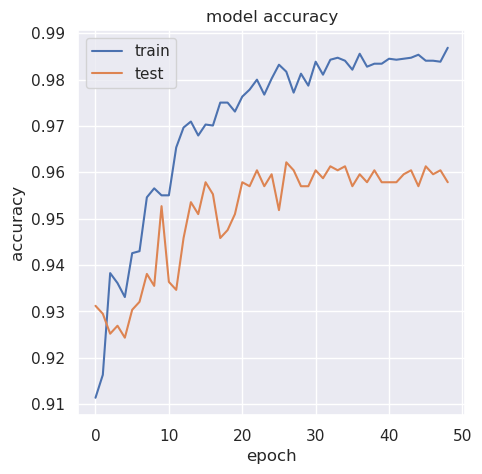

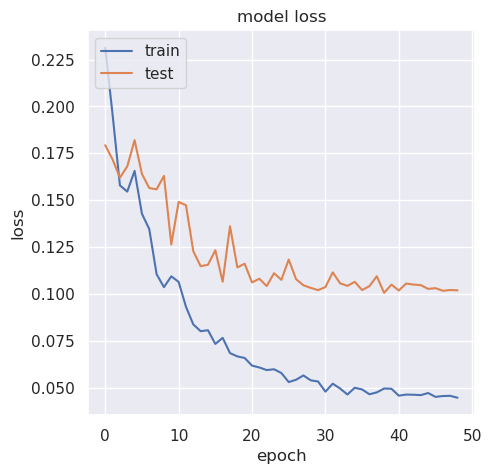

37/37 [==============================] - 0s 6ms/step - loss: 0.1079 - accuracy: 0.9622
Training for fold no 3

Epoch 1: val_accuracy improved from -inf to 0.93632, saving model to ./_best_model_3.h5

Epoch 2: val_accuracy improved from 0.93632 to 0.95525, saving model to ./_best_model_3.h5

Epoch 3: val_accuracy did not improve from 0.95525

Epoch 4: val_accuracy did not improve from 0.95525

Epoch 5: val_accuracy did not improve from 0.95525

Epoch 6: val_accuracy improved from 0.95525 to 0.95869, saving model to ./_best_model_3.h5

Epoch 7: val_accuracy did not improve from 0.95869

Epoch 8: val_accuracy improved from 0.95869 to 0.96816, saving model to ./_best_model_3.h5

Epoch 9: val_accuracy did not improve from 0.96816

Epoch 10: val_accuracy did not improve from 0.96816

Epoch 11: val_accuracy improved from 0.96816 to 0.96902, saving model to ./_best_model_3.h5

Epoch 12: val_accuracy did not improve from 0.96902

Epoch 13: val_accuracy did not improve from 0.96902

Epoch 14: va

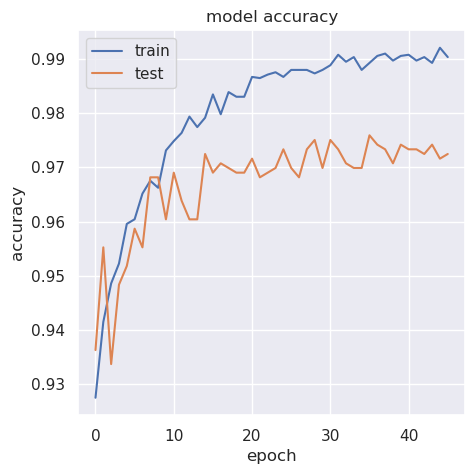

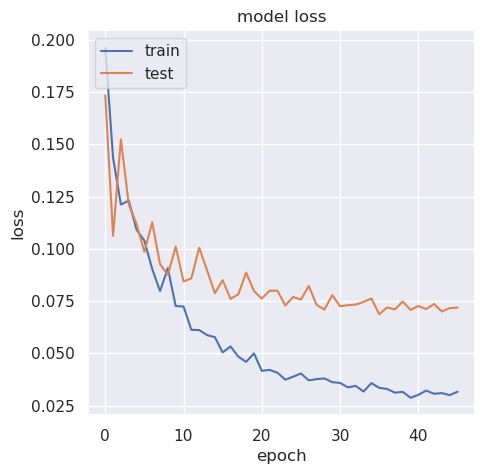

37/37 [==============================] - 0s 6ms/step - loss: 0.0687 - accuracy: 0.9759
Training for fold no 4

Epoch 1: val_accuracy improved from -inf to 0.96988, saving model to ./_best_model_4.h5

Epoch 2: val_accuracy improved from 0.96988 to 0.97504, saving model to ./_best_model_4.h5

Epoch 3: val_accuracy did not improve from 0.97504

Epoch 4: val_accuracy did not improve from 0.97504

Epoch 5: val_accuracy improved from 0.97504 to 0.98193, saving model to ./_best_model_4.h5

Epoch 6: val_accuracy did not improve from 0.98193

Epoch 7: val_accuracy improved from 0.98193 to 0.98537, saving model to ./_best_model_4.h5

Epoch 8: val_accuracy improved from 0.98537 to 0.98623, saving model to ./_best_model_4.h5

Epoch 9: val_accuracy did not improve from 0.98623

Epoch 10: val_accuracy did not improve from 0.98623

Epoch 11: val_accuracy did not improve from 0.98623

Epoch 12: val_accuracy did not improve from 0.98623

Epoch 13: val_accuracy did not improve from 0.98623

Epoch 14: va

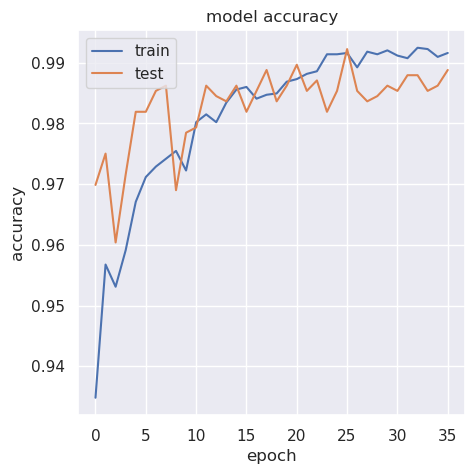

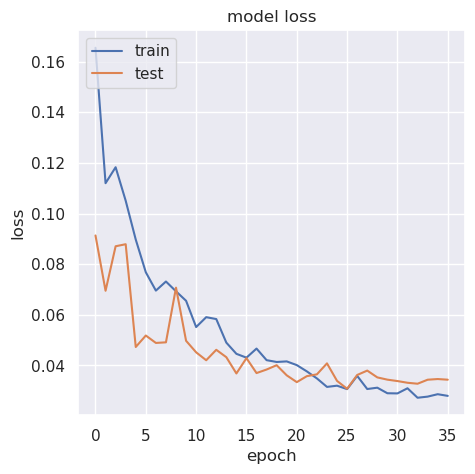

37/37 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9923
Training for fold no 5

Epoch 1: val_accuracy improved from -inf to 0.95955, saving model to ./_best_model_5.h5

Epoch 2: val_accuracy did not improve from 0.95955

Epoch 3: val_accuracy did not improve from 0.95955

Epoch 4: val_accuracy improved from 0.95955 to 0.98021, saving model to ./_best_model_5.h5

Epoch 5: val_accuracy improved from 0.98021 to 0.98107, saving model to ./_best_model_5.h5

Epoch 6: val_accuracy improved from 0.98107 to 0.98709, saving model to ./_best_model_5.h5

Epoch 7: val_accuracy did not improve from 0.98709

Epoch 8: val_accuracy did not improve from 0.98709

Epoch 9: val_accuracy did not improve from 0.98709

Epoch 10: val_accuracy did not improve from 0.98709

Epoch 11: val_accuracy did not improve from 0.98709

Epoch 12: val_accuracy improved from 0.98709 to 0.98881, saving model to ./_best_model_5.h5

Epoch 13: val_accuracy did not improve from 0.98881

Epoch 14: va

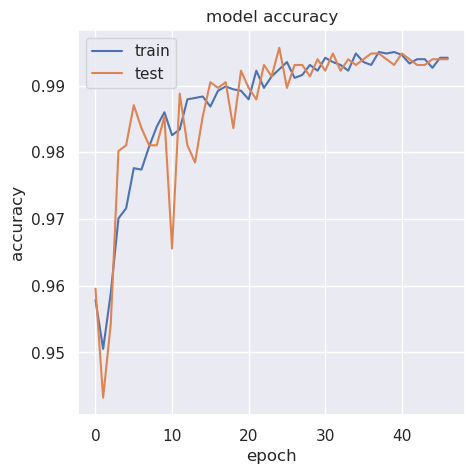

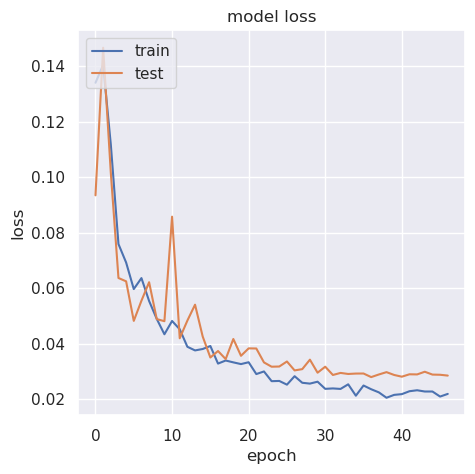

37/37 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.9957


In [22]:
from sklearn.model_selection import StratifiedKFold

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

# skf = StratifiedKFold(n_splits=5)
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True) 

for train_index, val_index in skf.split(x_lstm,y_lstm):
  x_train = x_lstm[train_index]
  y_train = y_lstm.iloc[train_index]
  x_test = x_lstm[val_index]
  y_test = y_lstm.iloc[val_index]


  model,history = train_model(model, x_train, y_train,x_test, y_test, save_to= './', kfold_order=fold_var, epoch = 100)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights("./_best_model_"+str(fold_var)+".h5")

  results = model.evaluate(x_test, y_test)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1

In [23]:
print("Average accuracy: "+str(sum(VALIDATION_ACCURACY) / len(VALIDATION_ACCURACY)))
print("Average loss: "+str(sum(VALIDATION_LOSS) / len(VALIDATION_LOSS)))
print("Max accuracy: "+str(max(VALIDATION_ACCURACY)))
print("Min accuracy: "+str(min(VALIDATION_ACCURACY)))

Average accuracy: 0.972306764125824
Average loss: 0.08724486604332923
Max accuracy: 0.9956970810890198
Min accuracy: 0.935511589050293


Once again, the cross-validation has produced promising results, with an average accuracy of 97.6% and a range of 94.1% to 99.6%.

To gain insight into why this improvement has occurred, we will plot the moving average data and compare it to the original data. Additionally, we will draw a correlation heatmap to observe any improvements in the correlation between each feature.

Original data


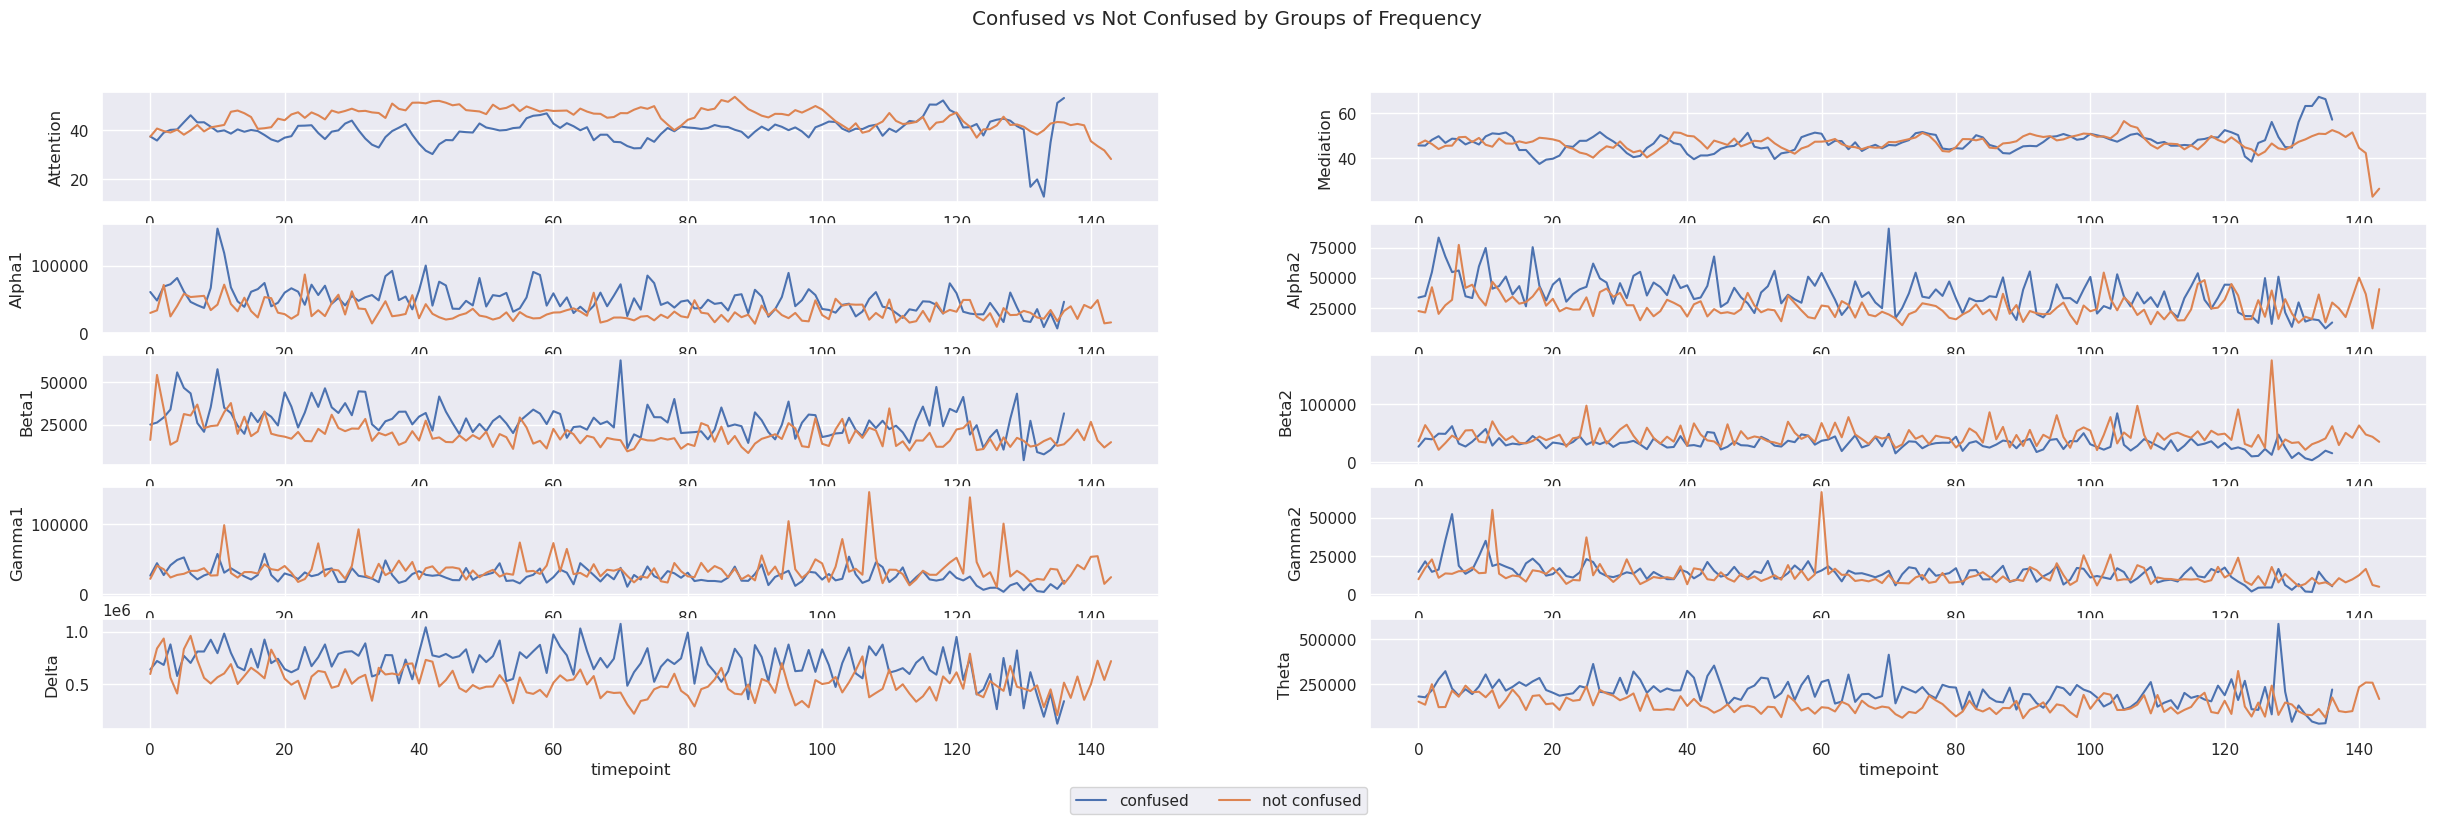

Data after applying moving average


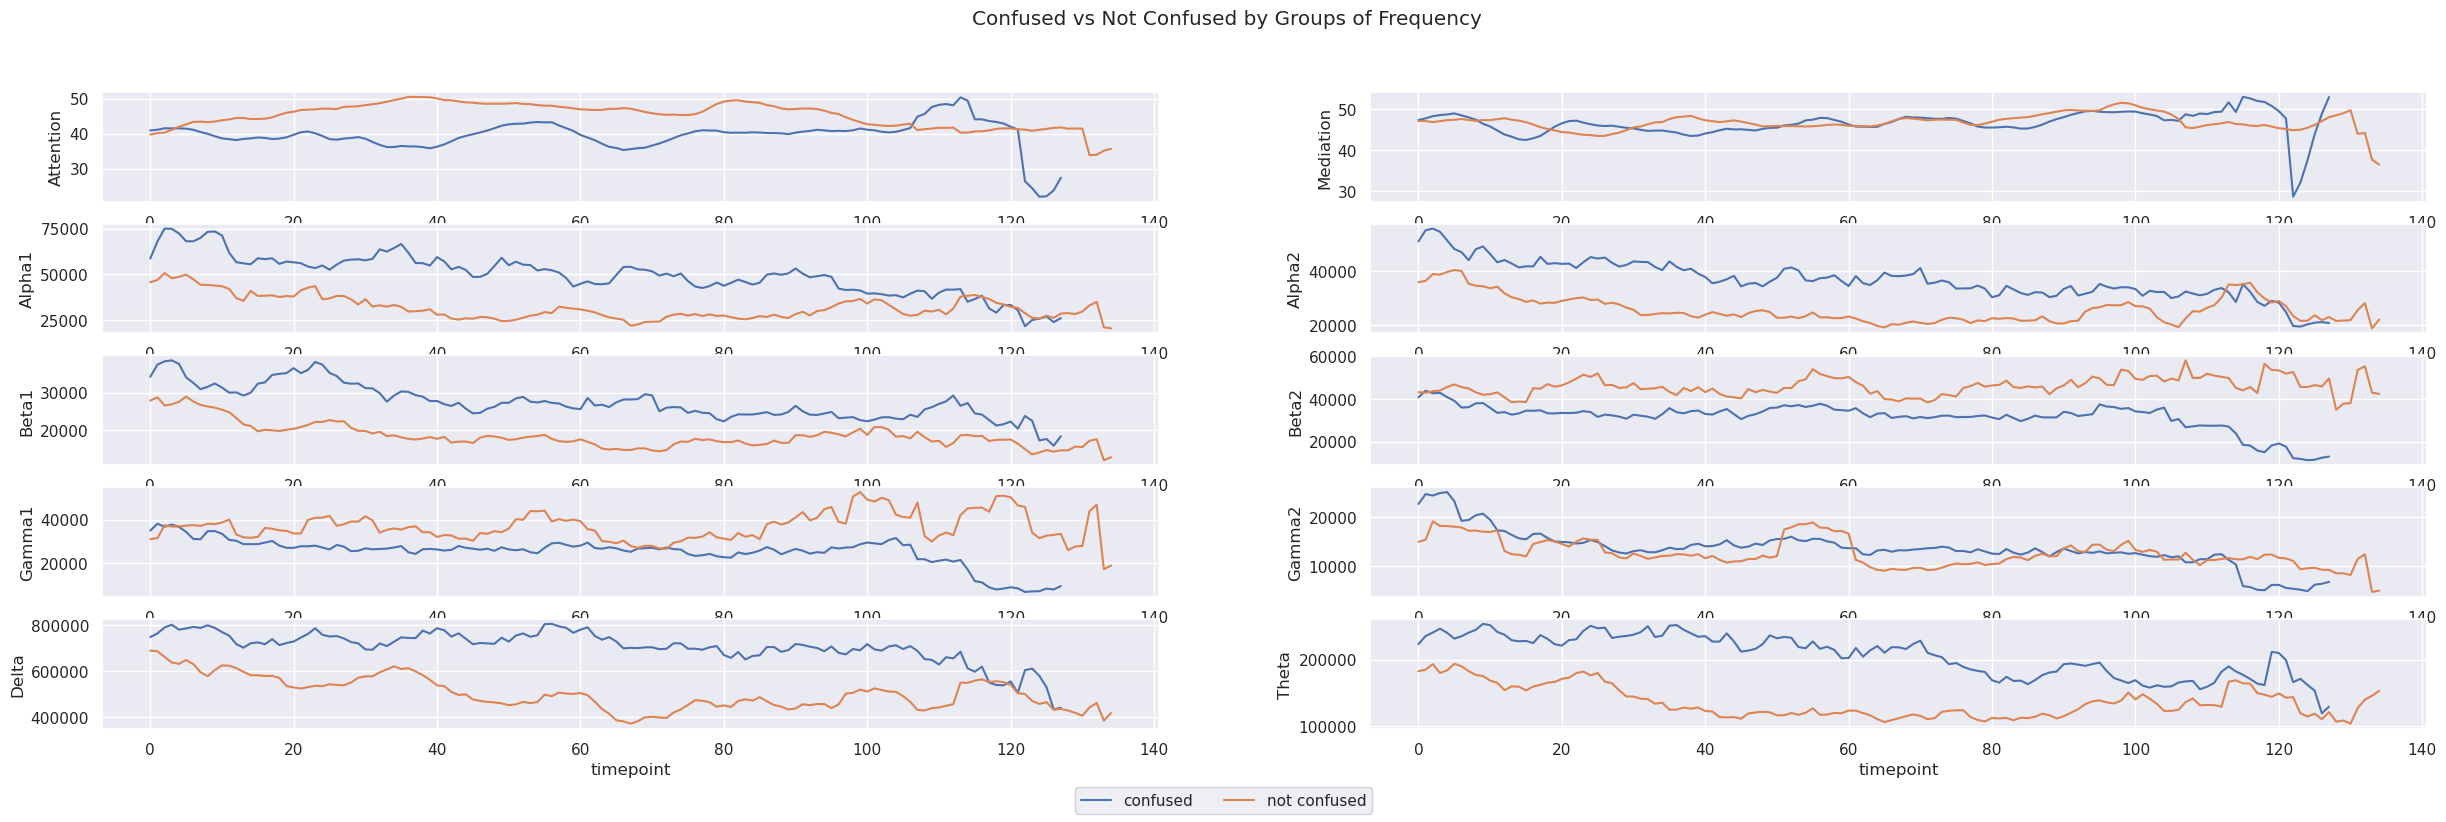

In [24]:
query = "predefinedlabel == 1 & userlabel == 1"
df_confused = df_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
df_understand = df_new.query(query)

print("===================================")
print("Original data")
print("===================================")
draw_multiple_figures(df_confused,df_understand)

query = "Label == 1"
df_confused = df_ma.query(query)

query = "Label == 0"
df_understand = df_ma.query(query)

print("===================================")
print("Data after applying moving average")
print("===================================")
draw_multiple_figures(df_confused,df_understand)


As observed from the charts above, the lines on the moving average data are more distinguishable between each label compared to the original data. Thus, it has contributed to increasing the classification ability.

<AxesSubplot:>

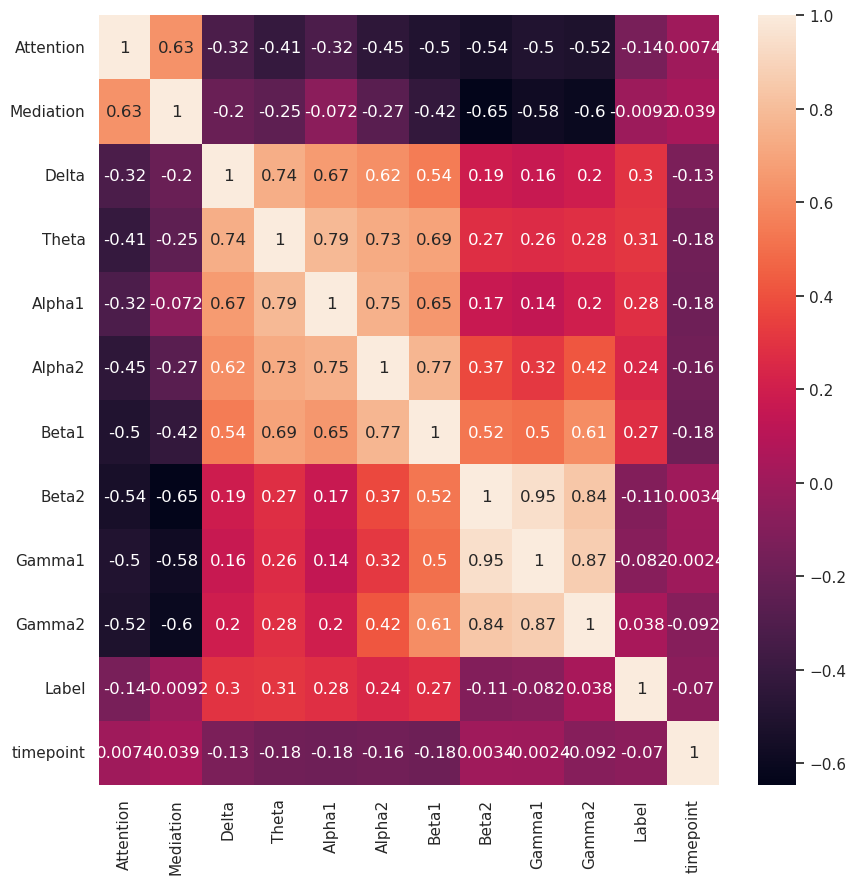

In [25]:
plt.figure(figsize = (10,10))
cor_matrix = df_ma.corr()
sns.heatmap(cor_matrix,annot=True)

Furthermore, the correlation heatmap of the moving average data demonstrates an improvement in the correlation score when compared to the original data.